In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import copy
import pandas as pd
import time

In [17]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.manifold import Isomap

#from umap import UMAP  # <-- THIS IS NOT PART OF SCIPY

In [6]:
from subspace_clustering_helper_funcs import *

- https://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold

## Loading in the data

In [2]:
# remove pID 101 because it doesn't exist
# remove pID 131 because it  doesnt have enough user defined gestures
# each participant has 100 experimenter defined files and 50 user defined files
# 10 experimenter defined gestures and 5 user defined gestures

file_types = ["IMU_extract", "movavg_files"]
expt_types = ["experimenter-defined"]

#remove participant 131 because they are missing gestures 
pIDs_impaired = ['P102','P103','P104','P105','P106','P107','P108','P109','P110','P111',
       'P112','P114','P115','P116','P118','P119','P121','P122','P123','P124','P125',
       'P126','P127','P128', 'P132']
# remove participants P001 and P003 because they dont have duplicate or open gestures
pIDs_unimpaired = ['P004','P005','P006','P008','P010','P011']

pIDs_both = pIDs_impaired + pIDs_unimpaired

In [9]:
## Pickle is theoretically faster for Python...
file_path_kai = 'C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\metadata_IMU_EMG_allgestures_allusers.pkl'
file_path_ben = "C:\\Users\\rubin\\Research\\metadata_IMU_EMG_allgestures_allusers.pkl"
print("Loading")
start_time = time.time()
data_df = pd.read_pickle(file_path_ben)
end_time = time.time()
print(f"Completed in {end_time - start_time}s")

Loading
Completed in 0.1369466781616211s


In [10]:
print(data_df.shape)
data_df.head()

(426752, 91)


,Participant,Gesture_ID,Gesture_Num,IMU1_ax,IMU1_ay,IMU1_az,IMU1_vx,IMU1_vy,IMU1_vz,IMU2_ax,...,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,0.341797,-0.939941,0.000977,-0.007450,-0.192625,0.005321,-0.380859,...,0.000002,0.000002,0.000003,0.000020,0.000004,0.000004,0.000002,0.000009,0.000001,0.000002
1,P102,pan,1,0.336178,-0.963185,0.003898,0.009595,-0.190446,-0.026116,-0.394547,...,0.000003,0.000003,0.000003,0.000014,0.000007,0.000007,0.000002,0.000017,0.000001,0.000002
2,P102,pan,1,0.353539,-0.963704,0.011711,0.095966,-0.205480,-0.155563,-0.398406,...,0.000003,0.000003,0.000004,0.000007,0.000004,0.000005,0.000003,0.000020,0.000003,0.000002
3,P102,pan,1,0.352841,-0.950288,0.011509,0.058836,-0.184871,-0.083567,-0.389230,...,0.000003,0.000003,0.000006,0.000005,0.000004,0.000003,0.000004,0.000015,0.000003,0.000003
4,P102,pan,1,0.372621,-0.991273,0.029847,0.293946,-0.178756,-0.281361,-0.396043,...,0.000003,0.000002,0.000008,0.000003,0.000007,0.000022,0.000004,0.000017,0.000002,0.000003


## creating standardized dataframe


In [22]:
trial_length = 64
num_trials = data_df.shape[0] // trial_length
standardized_data = []
index_cols = data_df.iloc[:, :3]
signal_cols = data_df.iloc[:, 3:]
for trial_idx in range(num_trials):
    start_idx = trial_idx * trial_length
    end_idx = start_idx + trial_length
    trial_data = signal_cols.iloc[start_idx:end_idx]
    scaler = StandardScaler()
    trial_data_standardized = scaler.fit_transform(trial_data)
    trial_data_standardized_df = pd.DataFrame(trial_data_standardized, columns=signal_cols.columns)
    standardized_data.append(trial_data_standardized_df)
standardized_df = pd.concat(standardized_data, ignore_index=True)
standardized_df = pd.concat([index_cols, standardized_df], axis=1)
print(standardized_df.shape)
print(standardized_df.head())
  
        
        
        
        


(426752, 91)
  Participant Gesture_ID Gesture_Num   IMU1_ax   IMU1_ay   IMU1_az   IMU1_vx  \
0        P102        pan           1 -1.062003 -0.858794 -1.280628  0.058372   
1        P102        pan           1 -1.100554 -0.954966 -1.267109  0.077843   
2        P102        pan           1 -0.981445 -0.957115 -1.230962  0.176508   
3        P102        pan           1 -0.986230 -0.901605 -1.231895  0.134093   
4        P102        pan           1 -0.850530 -1.071181 -1.147051  0.402669   

    IMU1_vy   IMU1_vz   IMU2_ax  ...      EMG7      EMG8      EMG9     EMG10  \
0  0.028126  0.053926  1.355325  ... -0.925569 -0.480126 -1.847291 -0.286930   
1  0.031786 -0.015429  1.292770  ... -0.421499  1.610438 -1.725413 -0.576721   
2  0.006533 -0.301011  1.275130  ... -0.229309  2.102434 -1.412565 -0.942372   
3  0.041150 -0.142176  1.317070  ... -0.197335  1.454171 -0.897182 -1.027206   
4  0.051421 -0.578542  1.285934  ... -0.013161  0.745722 -0.034943 -1.128485   

      EMG11     EMG12    

## creating subtracted means dataframe

In [26]:
trial_length = 64
num_trials = data_df.shape[0] // trial_length
mean_subtracted_data = []
index_cols = data_df.iloc[:, :3]
signal_cols = data_df.iloc[:, 3:]
for trial_idx in range(num_trials):
    start_idx = trial_idx * trial_length
    end_idx = start_idx + trial_length
    trial_data = signal_cols.iloc[start_idx:end_idx]
    trial_data_mean_subtracted = trial_data - trial_data.mean()
    trial_data_mean_subtracted_df = pd.DataFrame(trial_data_mean_subtracted, columns=signal_cols.columns)
    mean_subtracted_data.append(trial_data_mean_subtracted_df)
mean_subtracted_df = pd.concat(mean_subtracted_data, ignore_index=True)
mean_subtracted_df = pd.concat([index_cols, mean_subtracted_df], axis=1)
print(mean_subtracted_df.shape)
print(mean_subtracted_df.head())
  
        

(426752, 91)
  Participant Gesture_ID Gesture_Num   IMU1_ax   IMU1_ay   IMU1_az   IMU1_vx  \
0        P102        pan           1 -0.154795 -0.207561 -0.276788  0.051098   
1        P102        pan           1 -0.160414 -0.230805 -0.273866  0.068143   
2        P102        pan           1 -0.143053 -0.231324 -0.266054  0.154514   
3        P102        pan           1 -0.143750 -0.217908 -0.266255  0.117384   
4        P102        pan           1 -0.123971 -0.258893 -0.247918  0.352494   

    IMU1_vy   IMU1_vz   IMU2_ax  ...          EMG7          EMG8  \
0  0.016745  0.024443  0.296552  ... -1.519137e-06 -1.470037e-07   
1  0.018924 -0.006994  0.282865  ... -6.918069e-07  4.930801e-07   
2  0.003890 -0.136441  0.279005  ... -3.763653e-07  6.437183e-07   
3  0.024499 -0.064445  0.288182  ... -3.238861e-07  4.452346e-07   
4  0.030614 -0.262239  0.281369  ... -2.160070e-08  2.283233e-07   

           EMG9     EMG10         EMG11         EMG12         EMG13     EMG14  \
0 -4.804797e-06 

## Applying dimensionality reduction algorithms:

In [7]:
def apply_model(model_str, input_df, num_dims, hp):
    
    # Drop the metadata columns (eg cols that are not the actual timeseries data)
    #input_df.drop(columns=['Participant', 'Gesture_ID', 'Gesture_Num', 'Gesture_Type', 'File_Type'], inplace=True)
    training_df = input_df.drop(columns=['Participant', 'Gesture_ID', 'Gesture_Num'])
    
    if not training_df.empty:
        if model_str.upper() == 'PCA':
            dim_reduc_model = PCA(n_components=num_dims)
            dim_reduc_model.fit(training_df)
            reduced_df = pd.DataFrame(dim_reduc_model.transform(training_df))
        elif (model_str.upper() == 'T-SNE') or (model_str.upper() == 'TSNE'):
            dim_reduc_model = TSNE(n_components=num_dims, perplexity=hp, random_state=42)
            reduced_df = pd.DataFrame(dim_reduc_model.fit_transform(df))
        elif (model_str.upper() == 'INCREMENTALPCA') or (model_str.upper() == 'IPCA'):
            dim_reduc_model = IncrementalPCA(n_components=num_dims)
            reduced_df = pd.DataFrame(dim_reduc_model.fit_transform(training_df))
        elif (model_str.upper() == 'KERNELPCA') or (model_str.upper() == 'KPCA'):
            dim_reduc_model = KernelPCA(n_components=num_dims)
            reduced_df = pd.DataFrame(dim_reduc_model.fit_transform(training_df))
        #elif model_str.upper() == 'UMAP':
        #    raise ValueError("Need to install the umap library first...")
        #    dim_reduc_model = UMAP(n_components=num_dims)
        #    reduced_df = pd.DataFrame(dim_reduc_model.fit_transform(training_df))
        elif model_str.upper() == 'MDS':
            dim_reduc_model = MDS(n_components=num_dims, random_state=42)
            reduced_df = pd.DataFrame(dim_reduc_model.fit_transform(training_df))
        elif model_str.upper() == 'ISOMAP':
            dim_reduc_model = Isomap(n_components=num_dims)
            reduced_df = pd.DataFrame(dim_reduc_model.fit_transform(training_df))
        else:
            raise ValueError(f"{model_str} not implemented. Choose an implemented model.")
    else:
        raise ValueError(f"training_df is empty!")
    
    return reduced_df, dim_reduc_model

Testing in non-functionalized form first:

In [8]:
print("Start")

#def apply_dim_reduc(
model_str = 'PCA'
#data_df
num_dims=2
hp=None
modality=['EMG and IMU'],
participant_inclusion=['All'] #['Impaired', 'Unimpaired']

# ADD THIS TO FUNC!!!
apply='ALL'

###########################################

gestures = ['pan', 'duplicate', 'zoom-out', 'zoom-in', 'move', 'rotate', 'select-single', 'delete', 'close', 'open']
data_types = modality
participant_types = participant_inclusion

for f_type in data_types:
    # My code assumes you are doing EMG and IMU together...
    ## Add slicing functionality later
    if f_type[0] == 'EMG and IMU':
        sel_df = data_df
    #elif f_type[0] == 'IMU':
    #    # slice just the IMU columns (cols with IMU in name)
    #elif f_type[0] == 'EMG':
    #    # slice just the EMG columns (cols with EMG in name)
    else:
        raise ValueError(f"f_type {f_type} not found in [EMG, IMU, EMG and IMU]")

    for p_type in participant_types:
        if p_type == "All":
            pIDs = sel_df['Participant'].unique()
        elif p_type == "Impaired":
            # Idk what this indexing by ['Participant'] the second time is doing, presumably is broken
            pIDs = sel_df[sel_df['Participant'].isin(pIDs_impaired)]['Participant'].unique()
        elif p_type == "Unimpaired":
            # Idk what this indexing by ['Participant'] the second time is doing, presumably is broken
            pIDs = sel_df[sel_df['Participant'].isin(pIDs_unimpaired)]['Participant'].unique()
        else:
            raise ValueError(f"Participant type {p_type} not supported, check supported versions.")

        if apply.upper() == 'ALL':
            df_t, dim_reduc_model = apply_model(model_str, sel_df, num_dims, hp)
        elif apply.upper() == 'BY USER':
            for pid in pIDs:
                for file_type in file_types:
                        user_df = sel_df[(sel_df['Participant'] == pid)]
                        df_t, dim_reduc_model = apply_model(model_str, user_df, num_dims, hp)
        elif apply.upper() == 'BY GESTURE':
            for file_type in file_types:
                for gesture in gestures:
                    gesture_df = sel_df[(data_df['Gesture_ID'] == gesture)]
                    df_t, dim_reduc_model = apply_model(model_str, gesture_df, num_dims, hp)

    #return df_t, dim_reduc_model

print("Success")

Start
Success


In [9]:
def apply_dim_reduc(model_str, data_df, num_dims, hp=None, modality=['EMG and IMU'], participant_inclusion=['All Participants']):
    '''
    model_str: what kind of model to use (eg PCA, T-SNE, ...)
    data_df: df containing all the (training) data
    num_dims: how many dimensions/components should be used [HYPERPARAM!]
    hp: [hyperparams] use this to store 
    modality: ['EMG', 'IMU', 'EMG and IMU']
    '''
    
    pass
                

In [10]:
print(dim_reduc_model.explained_variance_)
print(dim_reduc_model.explained_variance_ratio_)

[2.11063503 1.48093676]
[0.20366441 0.14290207]


## Completely unfunctionalized, just applying on X (data_df minus metadata) directly

## Evaluation
> Eval of dim reduc... probably not that important, just figure out roughly what corresponds to at least 80% of explained variance, and then go straight to clustering

In [11]:
def eval_dim_reduc():
    # AIC? ...
    # For PCA can used explained variance
    ## Probably easier to not do this as a function, unless I use the same criteria for each method...
    pass

Once these work, combine all of these into the same for loop (eg so that you only apply PCA for all the comps once, and eval all the (working) metrics during that for loop as opposed to redoing PCA every singl time)

In [41]:
dfs = [data_df.iloc[:,3:], mean_subtracted_df.iloc[:,3:], standardized_df.iloc[:,3:]]
df_titles= ["raw data", "mean subtracted data", "standardized data"]

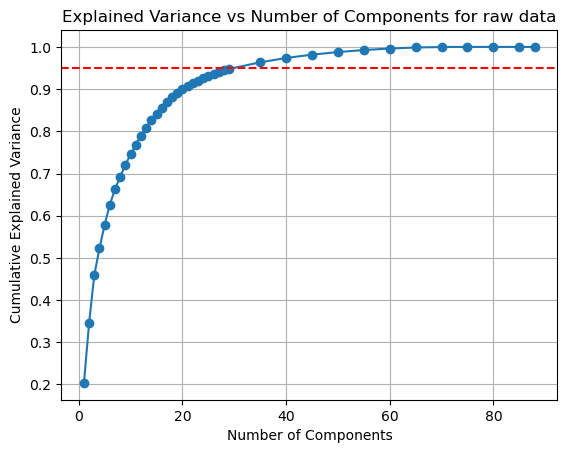

raw data minimum number of components = 35


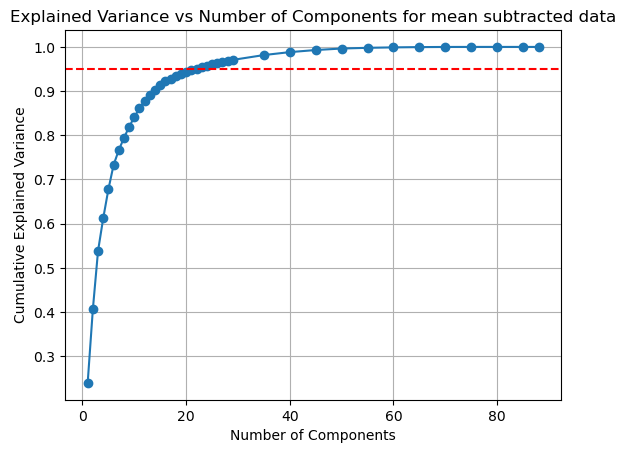

mean subtracted data minimum number of components = 22


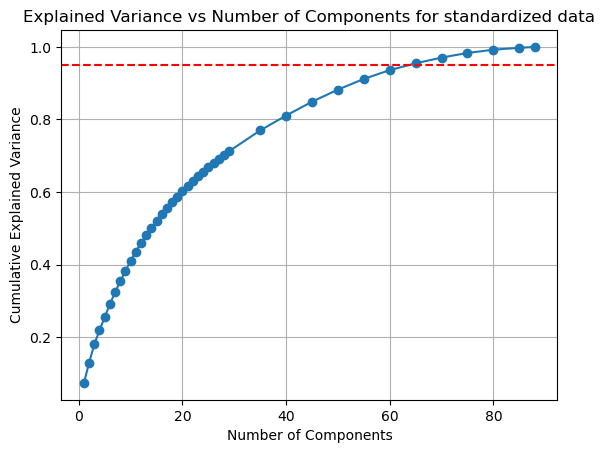

standardized data minimum number of components = 65


In [42]:
# Maximum number of components
def max_num_components(df, title):
    min_comps = df.shape[1]
    max_comps = df.shape[1]
    # Store explained variances for each number of components
    explained_variances = []
    
    # Create a combined range: 1-30, and then every 5th value after 30
    components_range = list(range(1, 30)) + list(range(35, max_comps + 1, 5))
    # Ensure max_comps is included if not already in the list
    if max_comps not in components_range:
        components_range.append(max_comps)
    
    for n in components_range:
        # print(f"{n}/{max_comps}")
        pca = PCA(n_components=n)
        pca.fit(df)
        explained_var = np.sum(pca.explained_variance_ratio_)
        explained_variances.append(explained_var)
        if n <= min_comps and explained_var > .95:
            min_comps = n
    # Plot the cumulative explained variance
    plt.plot(components_range, explained_variances, marker='o')
    plt.axhline(y=0.95, linestyle="--", color='r')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance vs Number of Components for '+ title)
    plt.grid(True)
    plt.show()
    print(title+ " minimum number of components = " + str(min_comps))
for i in range(3):
    max_num_components(dfs[i], df_titles[i])


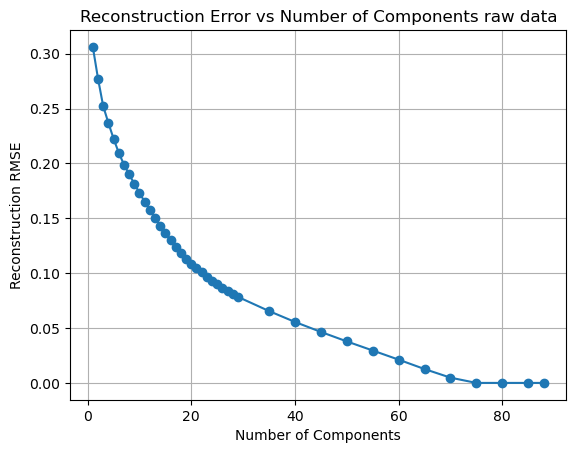

raw data minimum number of components = 45


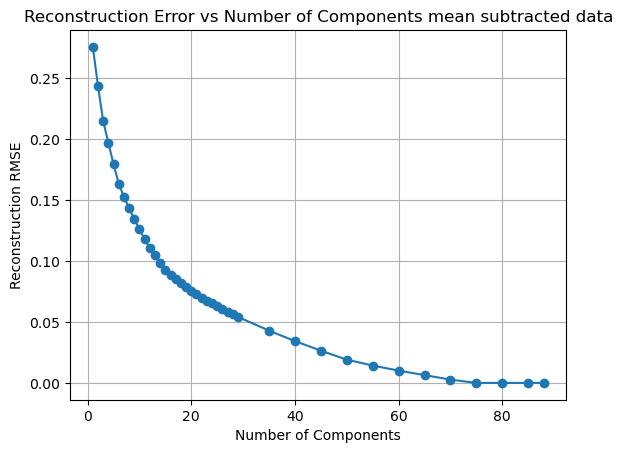

mean subtracted data minimum number of components = 35


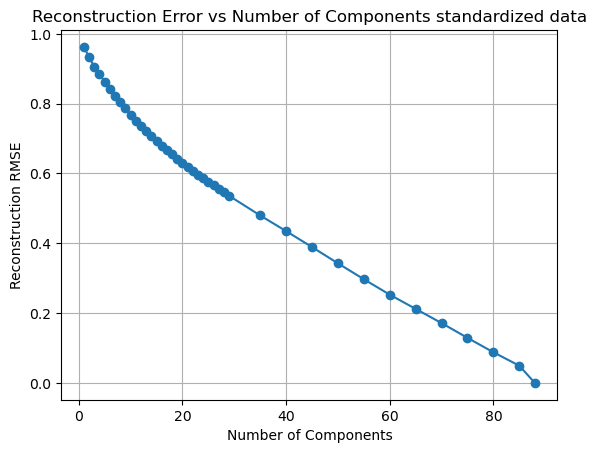

standardized data minimum number of components = 85


In [43]:
## 2. Reconstruction Error and RMSE

from sklearn.metrics import mean_squared_error
def reconstruction_rmse(df, title):
    min_comps = df.shape[1]
    max_comps = df.shape[1]
    # Create a combined range: 1-30, and then every 5th value after 30
    components_range = list(range(1, 30)) + list(range(35, max_comps + 1, 5))
    # Ensure max_comps is included if not already in the list
    if max_comps not in components_range:
        components_range.append(max_comps)
    reconstruction_errors = []
    for n in components_range:
        pca = PCA(n_components=n)
        df_reduced = pca.fit_transform(df)
        df_reconstructed = pca.inverse_transform(df_reduced)
        rmse = np.sqrt(mean_squared_error(df, df_reconstructed))
        reconstruction_errors.append(rmse)
        # not sure if .05 is proper benchmark
        if n <= min_comps and rmse < .05:
            min_comps = n
    
    # Plot the reconstruction error
    plt.plot(components_range, reconstruction_errors, marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Reconstruction RMSE')
    plt.title('Reconstruction Error vs Number of Components '+ title)
    plt.grid(True)
    plt.show()
    print(title+ " minimum number of components = " + str(min_comps))
for i in range(3):
    reconstruction_rmse(dfs[i], df_titles[i])

In [ ]:
assert(1==0)

In [25]:
## 3. Information-Theoretic Measures: Mutual Information and Entropy

from sklearn.feature_selection import mutual_info_regression

# Mutual Information
mutual_info_scores = []

X_npy = X.to_numpy()

for n in components_range:
    print(f"{n}/{max_comps}")
    pca = PCA(n_components=n)
    X_reduced = pca.fit_transform(X_npy)
    
    #mutual_info = np.mean([mutual_info_regression(X[:, i].reshape(-1, 1), X_reduced[:, j])[0] for i in range(X.shape[1]) for j in range(n)])
    # Fixed iloc version?:
    #mutual_info = np.mean([mutual_info_regression(X.iloc[:, i].reshape(-1, 1), X_reduced[:, j])[0] for i in range(X.shape[1]) for j in range(n)])
    #mutual_info_scores.append(mutual_info)
    total_mutual_info = 0
    count = 0
    for i in range(X_npy.shape[1]):  # Loop over each original feature
        for j in range(X_reduced.shape[1]):  # Loop over each reduced feature
            # Calculate mutual information between original feature i and reduced feature j
            mutual_info = mutual_info_regression(X_npy[:, i].reshape(-1, 1), X_reduced[:, j])
            total_mutual_info += mutual_info[0]
            count += 1
    # Calculate the average mutual information
    average_mutual_info = total_mutual_info / count
    mutual_info_scores.append(average_mutual_info)

# Plot the mutual information scores
plt.plot(components_range, mutual_info_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Average Mutual Information')
plt.title('Mutual Information vs Number of Components')
plt.grid(True)
plt.show()


1/88
2/88
3/88
4/88


KeyboardInterrupt: 

In [ ]:
assert(1==0)

Cluster-based evaluation methods. Could be worth trying
> Note that n_clusters is a new hyperparam, will of course change the results a lot. Come back after downstream clustering has found the optimal number of clusters?

In [ ]:
## 4. Clustering and Classification Performance

# Clustering: Silhouette Score
silhouette_scores = []

for n in components_range:
    pca = PCA(n_components=n)
    X_reduced = pca.fit_transform(X)
    # So it just totally randomly chose 3 here lol
    kmeans = KMeans(n_clusters=3)
    cluster_labels = kmeans.fit_predict(X_reduced)
    silhouette = silhouette_score(X_reduced, cluster_labels)
    silhouette_scores.append(silhouette)

# Plot the silhouette scores
plt.plot(components_range, silhouette_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Components')
plt.grid(True)
plt.show()

In [ ]:
# Classification: Accuracy and F1 Score
classification_accuracies = []
classification_f1_scores = []

# Assuming `y` is your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# This actually did a train/test split... I should do this manually...
for n in components_range:
    pca = PCA(n_components=n)
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_reduced, y_train)
    y_pred = clf.predict(X_test_reduced)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    classification_accuracies.append(accuracy)
    classification_f1_scores.append(f1)

# Plot the classification accuracies
plt.plot(components_range, classification_accuracies, marker='o', label='Accuracy')
plt.plot(components_range, classification_f1_scores, marker='o', label='F1 Score')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('Classification Performance vs Number of Components')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
## Topological Measures: Neighborhood Preservation
# This one also uses an arbitrary number of clusters...

from sklearn.neighbors import NearestNeighbors

def knn_preservation_score(X_orig, X_reduced, k=5):
    knn_orig = NearestNeighbors(n_neighbors=k).fit(X_orig)
    knn_reduced = NearestNeighbors(n_neighbors=k).fit(X_reduced)
    neighbors_orig = knn_orig.kneighbors(X_orig, return_distance=False)
    neighbors_reduced = knn_reduced.kneighbors(X_reduced, return_distance=False)
    preservation = np.mean([len(set(neighbors_orig[i]).intersection(set(neighbors_reduced[i]))) / k for i in range(X_orig.shape[0])])
    return preservation

preservation_scores = []

for n in components_range:
    pca = PCA(n_components=n)
    X_reduced = pca.fit_transform(X)
    score = knn_preservation_score(X, X_reduced)
    preservation_scores.append(score)

# Plot the neighborhood preservation scores
plt.plot(components_range, preservation_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Neighborhood Preservation Score')
plt.title('Neighborhood Preservation vs Number of Components')
plt.grid(True)
plt.show()

This distance can only be used with matrices of the same size... so this doesn't work I don't think

In [ ]:
## 7. Distance Metrics: Pairwise Distances

from scipy.spatial import procrustes

procrustes_distances = []

for n in components_range:
    pca = PCA(n_components=n)
    X_reduced = pca.fit_transform(X)
    _, _, distance = procrustes(X, X_reduced)
    procrustes_distances.append(distance)

# Plot the Procrustes distances
plt.plot(components_range, procrustes_distances, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Procrustes Distance')
plt.title('Procrustes Distance vs Number of Components')
plt.grid(True)
plt.show()

We don't have cluster labels y so I don't think we can use this?

In [ ]:
## 8. Cross-Validation Techniques

from sklearn.model_selection import cross_val_score

cv_accuracies = []

for n in components_range:
    pca = PCA(n_components=n)
    X_reduced = pca.fit_transform(X)
    clf = LogisticRegression(max_iter=1000)
    scores = cross_val_score(clf, X_reduced, y, cv=5, scoring='accuracy')
    cv_accuracies.append(np.mean(scores))

# Plot the cross-validation accuracies
plt.plot(components_range, cv_accuracies, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Cross-Validation Accuracy vs Number of Components')
plt.grid(True)
plt.show()
